# Merge the geocoded EUC and the mobility dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
euc = pd.read_csv("../datasets/EUC_geocoded_clean.csv")
mob = pd.read_excel("../datasets/Student_Mobility_2013-14.xlsx")

In [4]:
# Select only the students that are SMS mobility type
mob = mob[mob.MobilityType == "Mob-SMS"]

In [5]:
# There are no duplicates
mob.duplicated().value_counts()

False    212208
dtype: int64

In [6]:
# Select only the columns which need to be used
mob = mob[["ParticipantGender", "SendingPartnerErasmusID", "HostingPartnerErasmusID"]]

In [7]:
merge = mob.merge(euc, left_on="SendingPartnerErasmusID", right_on="Institutional code", how="inner")

In [8]:
merge = merge.merge(euc, left_on="HostingPartnerErasmusID", right_on="Institutional code", how="inner", 
                    suffixes={"Sending", "Hosting"})

In [9]:
print("Lost {:0.3f}% in the merging.".format((100 - (len(merge) / len(mob))*100)))

Lost 2.082% in the merging.


In [10]:
merge = merge[["ParticipantGender", "CountryHosting", "CountrySending" ,"coordinatesHosting", "coordinatesSending"]]

In [11]:
cmerge = merge.copy()

In [12]:
cmerge.coordinatesHosting = cmerge.coordinatesHosting.str.strip("()").str.split(",")
cmerge.coordinatesSending = cmerge.coordinatesSending.str.strip("()").str.split(",")

In [13]:
cmerge["latHosting"] = cmerge.coordinatesHosting.apply(lambda x: float(x[0]))
cmerge["lonHosting"] = cmerge.coordinatesHosting.apply(lambda x: float(x[1]))
cmerge["latSending"] = cmerge.coordinatesSending.apply(lambda x: float(x[0]))
cmerge["lonSending"] = cmerge.coordinatesSending.apply(lambda x: float(x[1]))

In [14]:
from geopy import distance

cmerge['km'] = cmerge.apply(lambda row: distance.distance(
        (row["latHosting"], row["lonHosting"]), (row["latSending"], row["lonSending"])).km, axis=1
)

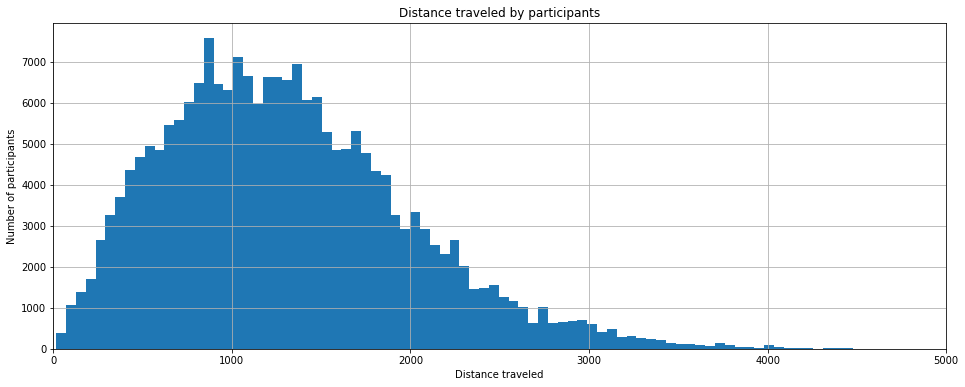

In [15]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlim(0, 5000)
ax.set_title("Distance traveled by participants")
ax.set_xlabel("Distance traveled")
ax.set_ylabel("Number of participants")
cmerge.km.hist(bins=300, ax=ax)

In [16]:
cmerge = cmerge.drop(columns=["coordinatesHosting", "coordinatesSending"])

In [200]:
cmerge.to_csv("finished_questions/travel_distance/distance_raw.csv", index=False)

In [17]:
production = cmerge.copy()

In [18]:
production = production[["CountrySending", "km"]]

In [217]:
from matplotlib import cm

In [219]:
cm.jet(len)

(0.0, 0.0, 0.517825311942959, 1.0)

In [221]:
gb = production.groupby(by="CountrySending").mean().sort_values(by="km")

In [226]:
cols = []
for i in range(len(gb)):
    cols.append(cm.jet(i))

In [21]:
mean = production.groupby(by="CountrySending").mean()

In [22]:
std = production.groupby(by="CountrySending").std()

In [27]:
mean["std"] = std.km

In [31]:
mean.rename(columns={"km": "km_distance", "std": "km_deviation"}).to_csv("../datasets/country_distance.csv", index=True)

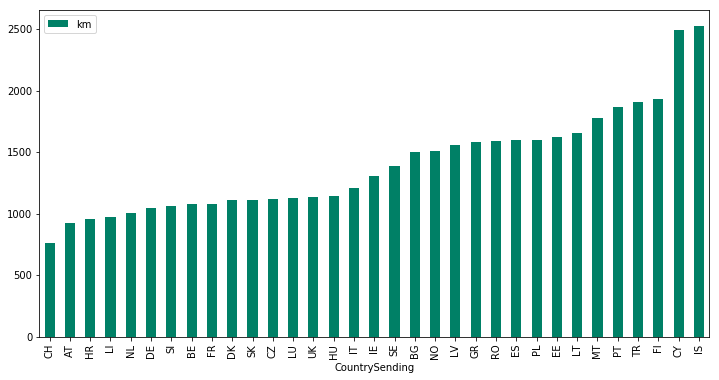

In [240]:
fig, ax = plt.subplots(figsize=(12, 6))
production.groupby(by="CountrySending").mean().sort_values(by="km").plot(kind="bar", ax=ax, colormap='summer')

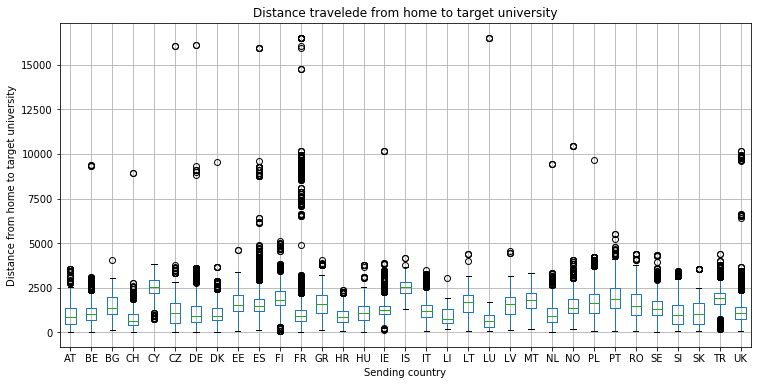

In [249]:
fig, ax = plt.subplots(figsize=(12, 6))
production.boxplot(column="km", by="CountrySending", ax=ax)
fig.suptitle('')
ax.set_title("Distance travelede from home to target university")
ax.set_xlabel("Sending country")
ax.set_ylabel("Distance from home to target university")
plt.show()